In [1]:
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pypylon import pylon
from camera import BaslerCamera, list_basler_cameras
import subprocess as sp
import os
import traceback


def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

# dont use gpu
# tf.config.set_visible_devices([], 'GPU')

# Set GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
print("GPUs Available:")
for gpu in gpus:
    print(gpu)
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      print("Setting memory growth for GPU:", gpu)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# list available cameras
print("Cameras Available:")
cameras = list_basler_cameras()


# Acquisition Parameters
EXPOSURE_TIME, GAIN, CAMERA_FORMAT, WIDTH, HEIGHT, OFFSETX, OFFSETY = 10000, 30, "Mono8", 2048, 2048, 0, 0

2024-07-24 15:37:19.001388: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-24 15:37:19.086497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 15:37:19.134464: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 15:37:19.145417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 15:37:19.219330: I tensorflow/core/platform/cpu_feature_guar

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

In [2]:
# get a single image from the camera
with BaslerCamera(
    index=0,
    FPS=100,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    image = camera.get_array()
    camera.stop()

Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 10000 microseconds.
Gain set to 30 dB.
Set width to 2048, height to 2048, offset to (0, 0).
Camera initialized.


/home/rutalab/FlyProjection/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 2048, 2048, 32) │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 1024, 1024, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 1024, 1024, 64) │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 1024, 1024, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 2048, 2048, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2048, 2048, 32) │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2048, 2048, 1)  │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

I0000 00:00:1721683511.153042  529214 service.cc:146] XLA service 0x720958058630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721683511.153062  529214 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-22 17:25:11.158609: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-22 17:25:11.185744: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1721683511.506960  529214 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1721683511.609723  529214 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024-07-22 17:25:13.244760: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1721683513.275231  529214 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


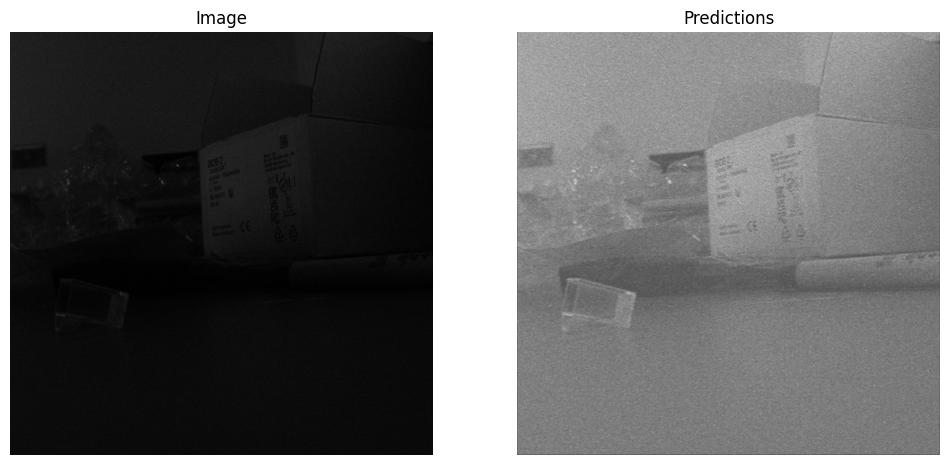

: 

In [3]:
# create a random convolutional neural network for testing

# create a unet model
model = tf.keras.models.Sequential(
    [
        # Encoder
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(WIDTH, HEIGHT, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        
        # Decoder
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    ]
)


# compile the model
model.compile(
    optimizer='adam', # optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function
    metrics=['accuracy'] # metrics
)

# print model summary
model.summary()

# pass the image through the model
predictions = model.predict(image.reshape(1, WIDTH, HEIGHT, 1))

# plot the image and the predictions
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Image")
ax[0].axis('off')
ax[1].imshow(predictions[0], cmap='gray')
ax[1].set_title("Predictions")
ax[1].axis('off')
plt.show()

In [4]:
# create an acquisition + prediction loop

update_period = 1 # seconds

previous_time = time.perf_counter()
last_display = time.perf_counter() - 1.1*update_period

fps = []

# setup live frame rate and gpu memory plot
%matplotlib qt
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax.set_title("Resource Usage")
ax.set_xlabel("Frame")
ax.set_ylabel("FPS (Hz)", color='k')
ax.grid()
line1, = ax.plot([], [], 'k-')
plt.tight_layout()
plt.ion()
plt.show()

BATCH_SIZE = 2

# WARM UP THE GPU
start_time = time.perf_counter()
while time.perf_counter() - start_time < 10:
    image = np.random.rand(1, WIDTH, HEIGHT, 1)
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.repeat(image, BATCH_SIZE, axis=0)
    predictions = model.predict(image, verbose=0)

# dont use the gpu for this
with BaslerCamera(
    index=0,
    FPS=100,
    EXPOSURE_TIME=EXPOSURE_TIME,
    GAIN=GAIN,
    WIDTH=WIDTH,
    HEIGHT=HEIGHT,
    OFFSETX=OFFSETX,
    OFFSETY=OFFSETY,
    TRIGGER_MODE="Continuous",
    CAMERA_FORMAT=CAMERA_FORMAT,
    record_video=False,
    video_output_path=None,
    video_output_name=None,
    lossless=True,
    debug=False,
) as camera:
    camera.start()
    try:
        while True:
            image = camera.get_array()
            # put the image on the gpu
            image = tf.convert_to_tensor(image.reshape(1, WIDTH, HEIGHT, 1), dtype=tf.float32)
            # repeat the image to match the batch size
            # pass the image through the model
            image = tf.repeat(image, BATCH_SIZE, axis=0)
            predictions = model.predict(image, verbose=0)
            # track frame rate
            current_time = time.perf_counter()
            frame_rate = 1 / (current_time - previous_time)
            previous_time = current_time
            fps.append(frame_rate)
            if current_time - last_display > update_period:
                last_display = current_time
                # update the plot
                line1.set_xdata(range(len(fps)))
                line1.set_ydata(fps)
                ax.relim()
                ax.autoscale_view()
                fig.canvas.draw()
                fig.canvas.flush_events()
    except KeyboardInterrupt:
        pass
    except Exception as e:
        # get stack trace and save to file
        with open("error.txt", "w") as f:
            f.write(str(e))
            f.write("\n")
            f.write(str(sys.exc_info()))
            f.write("\n")
            f.write(traceback.format_exc())
    # save the data
    np.save("fps.npy", fps)
    camera.stop()

E0000 00:00:1721683514.213871  529211 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1721683514.316896  529211 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


Trigger mode set to Continuous. FPS will be ignored.
Getting camera...
a2A2448-105g5m_40490701
Found 1 cameras.
Camera a2A2448-105g5m_40490701 selected.
Registered continuous acquisition configuration.
MaxNumBuffer set to 763200. Acquisitions will be limited to 2 hours. To change, modify the code.
Camera initialized.
Exposure time set to 10000 microseconds.
Gain set to 30 dB.
Set width to 2048, height to 2048, offset to (0, 0).
Camera initialized.


In [7]:
plt.plot(fps)